<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/Mass%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eagleSqlTools
!pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 4.6 MB/s 


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
from colossus.cosmology import cosmology
from colossus.lss import mass_function

con = sql.connect("vwg533", password = "FZtn087h")

In [3]:
cosmology.setCosmology('WMAP9')
# mfunc_fof = mass_function.massFunction(1E12, 0.0, mdef = 'fof', model = 'watson13')

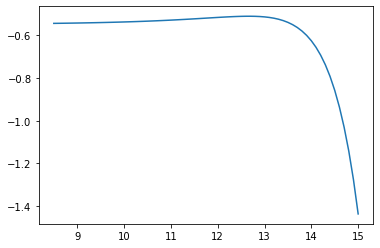

In [4]:
powers = np.arange(8.5,15.1, 0.1)
masses = 10**powers
mfunc = []

for i in range (len(masses)):
  mfunc = mfunc + [mass_function.massFunction(masses[i], 0.0, mdef = 'fof', model = 'watson13')]# mdef = 'vir', model = 'tinker08')]

plt.figure()

plt.plot(np.log10(masses), np.log10(mfunc))

plt.show()

In [36]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(FOF.Group_M_Crit200)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH, \
          %s_FOF as FOF \
        WHERE \
          SH.SnapNum = 27 and \
          SH.GroupID = FOF.GroupID and \
          FOF.Group_M_Crit200 > 1e12 \
        GROUP BY \
          0.1+floor(log10(FOF.Group_M_Crit200)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

In [15]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(SH.MassType_DM)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH \
        WHERE \
          SH.SnapNum = 27 and \
          SH.MassType_DM > 1e12 \
        GROUP BY \
          0.1+floor(log10(SH.MassType_DM)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

In [19]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(AP.Mass_DM)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH, \
          %s_Aperture as AP \
        WHERE \
          SH.GalaxyID = AP.GalaxyID and \
          AP.Mass_DM > 1e12 and \
          SH.SnapNum = 27 \
        GROUP BY \
          0.1+floor(log10(AP.Mass_DM)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

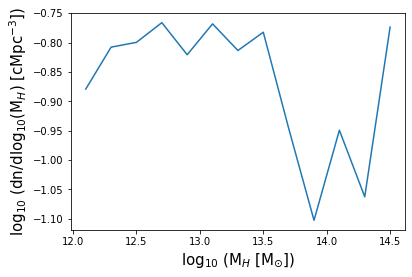

In [37]:
hist = Results['num'][:] / float(sim_size)**3.
hist = hist / bin_width

plt.figure()

plt.plot(Results['mass'], np.log10(hist))

plt.xlabel(r'log$_{10}$ (M$_{H}$ [M$_{\odot}$])', fontsize=15)
plt.ylabel(r'log$_{10}$ (dn/dlog$_{10}$(M$_{H}$) [cMpc$^{-3}$])', fontsize=15)

plt.show()